## 迁移学习

训练参数设置

In [3]:
# pre_features_files = {'ResNet50':'ResNet50_pre_out.h5', 'Xception':'Xception_pre_out.h5', 'InceptionV3':'InceptionV3_pre_out.h5'}
pre_features_files = {'ResNet50':'ResNet50_pre_out.h5', 
                      'Xception':'Xception_pre_out.h5', 
                      'InceptionResNetV2':'InceptionResNetV2_pre_out.h5'}

composite_model = False
single_model = 'ResNet50'

# check training parameter
if not composite_model and single_model not in pre_features_files:
    print("%s not found in pre-trained models" %single_model)
else:
    if composite_model:
        print("will use composite model")
    else:
        print("will use %s model" %single_model)
        
if composite_model:
    model_name = 'Composite_Model'
else:
    model_name = single_model

will use ResNet50 model


### Tools

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def show_history(hist, title_name):
    # epoch as x-axis 
    epochs = range(len(hist['acc']))
    
    fig, ax1 = plt.subplots()
    
    ## left scale: acc, val_acc
    # acc
    line_acc = ax1.plot(epochs, hist['acc'], 'r', label='acc')
    # loss
#     ax1.plot(epochs, hist['loss'], 'g', label='loss')
    # val_acc
    line_val_acc = ax1.plot(epochs, hist['val_acc'], 'b', label='val_acc')
    # val_loss
#     ax1.plot(epochs, hist['val_loss'], 'k', label='val_loss')
    
    ax1.set(xlabel='epochs', ylabel='acc',title=title_name)
    
    ## right scale: loss, val_loss
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('loss', color=color)  # we already handled the x-label with ax1
    line_loss = ax2.plot(epochs, hist['loss'], 'g', label='loss')
    line_val_loss = ax2.plot(epochs, hist['val_loss'], 'k', label='val_loss')
    ax2.tick_params(axis='y', labelcolor=color)

#     ax1.legend(loc='upper right', fancybox=True,)
#     ax2.legend(loc='lower right', fancybox=True)
    
    ax1.grid(True)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    acc_patch = mpatches.Patch(color='r', label='acc',linestyle='-')
    val_acc_patch = mpatches.Patch(color='b', label='val-acc')
    loss_patch = mpatches.Patch(color='g', label='loss')
    val_loss_patch = mpatches.Patch(color='k', label='val-loss')
    fig.legend(handles=[acc_patch, val_acc_patch, loss_patch, val_loss_patch],
               ncol=4, loc='lower center',
               mode="expand", borderaxespad=0.)

    fig.show()

### 载入数据

In [5]:
import h5py
import numpy as np
from sklearn.utils import shuffle
np.random.seed(66)

train_data = []
test_data = []

# #------- single pre-trained model
if not composite_model:
    with h5py.File(pre_features_files[single_model] , 'r') as h:
        train_data.append(np.array(h['train']))
        train_labels = np.array(h['label'])
        test_data.append(np.array(h['test']))
else:#-------- composite model
    for model_name in pre_features_files:
        with h5py.File(pre_features_files[model_name]) as h:
            train_data.append(np.array(h['train']))
            train_labels = np.array(h['label'])
            test_data.append(np.array(h['test']))

train_data = np.concatenate(train_data, axis=1)
test_data = np.concatenate(test_data, axis=1)

print("train shape:",train_data.shape)
print("train_data:",train_data[:5])
# 预存的X_train, y_train是按顺序存放的，前12500是猫，后12500是狗, 这里打乱顺序，使之随机存放
# Note: 打乱的是存放存放顺序，并不改变 X_train , y_train的对应关系
train_data, train_labels = shuffle(train_data, train_labels)

train shape: (25000, 2048)
train_data: [[1.3793691e+00 3.2003590e-01 1.0971487e+00 ... 4.3585628e-02
  5.8316565e-01 2.6179781e-02]
 [3.0272076e-01 7.6675266e-01 4.6666335e-02 ... 1.0106382e+00
  1.3519109e-02 1.8962671e-04]
 [5.9700817e-02 0.0000000e+00 1.7577169e-02 ... 2.9484406e-01
  3.0311666e-02 5.3556067e-01]
 [1.6001272e+00 2.5814738e-02 8.6979322e-02 ... 0.0000000e+00
  2.6098660e-01 2.9547337e-01]
 [0.0000000e+00 2.6336735e-01 6.6998944e-02 ... 2.7044544e-02
  2.5744811e-01 0.0000000e+00]]


### 构建模型

```
from keras.models import Sequential
from keras.models import Model
from keras.layers import GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Input

# from keras.applications import xception
input_tensor=Input(train_data.shape[1:])

model = Sequential()
model.add(Flatten(input_tensor))
model.add(Dense(1, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
        
 ```

In [8]:
from keras.models import Sequential
from keras.models import Model
from keras.layers import GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Input
import numpy as np

np.random.seed(666)

input_tensor = Input(train_data.shape[1:])
x = Dropout(0.5)(input_tensor)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### 在pre-train features上训练模型

Train on 20000 samples, validate on 5000 samples
Epoch 1/8
20000/20000 [==============================] - 2s 80us/step - loss: 0.2142 - acc: 0.9127 - val_loss: 0.0810 - val_acc: 0.9678
Epoch 2/8
20000/20000 [==============================] - 1s 59us/step - loss: 0.0951 - acc: 0.9630 - val_loss: 0.0707 - val_acc: 0.9736
Epoch 3/8
20000/20000 [==============================] - 1s 63us/step - loss: 0.0820 - acc: 0.9683 - val_loss: 0.0680 - val_acc: 0.9746
Epoch 4/8
20000/20000 [==============================] - 2s 81us/step - loss: 0.0754 - acc: 0.9715 - val_loss: 0.0599 - val_acc: 0.9762
Epoch 5/8
20000/20000 [==============================] - 1s 62us/step - loss: 0.0743 - acc: 0.9715 - val_loss: 0.0569 - val_acc: 0.9782
Epoch 6/8
20000/20000 [==============================] - 1s 60us/step - loss: 0.0714 - acc: 0.9728 - val_loss: 0.0560 - val_acc: 0.9792
Epoch 7/8
20000/20000 [==============================] - 2s 78us/step - loss: 0.0673 - acc: 0.9733 - val_loss: 0.0568 - val_acc: 0.9784

/home/jerry/.local/lib/python3.5/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


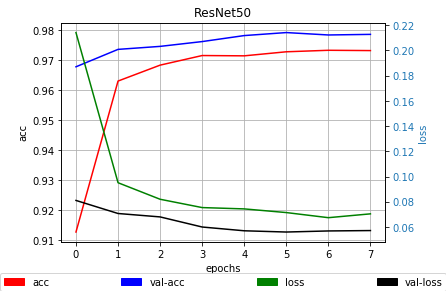

In [9]:
model_hist = model.fit(train_data, train_labels,
                       batch_size=128,epochs=8,
                       validation_split = 0.2,
                       verbose=1
          )

show_history(model_hist.history, model_name)

In [24]:
logpath = 'log/'+model_name
    
model.save(logpath+'.h5')
with open(logpath+'_hist.txt','w') as f:
    f.write(str(model_hist.history))

{'acc': [0.91715, 0.96515, 0.96725, 0.9714, 0.97325, 0.97265, 0.97455, 0.974, 0.97415, 0.97395, 0.9738, 0.97465, 0.97565, 0.974, 0.97555, 0.97515, 0.9752, 0.97685, 0.97625, 0.97525, 0.97485, 0.97565, 0.9746, 0.97425, 0.9758, 0.97525, 0.97595, 0.9747, 0.9754, 0.97525], 'val_acc': [0.97, 0.9746, 0.9758, 0.976, 0.9778, 0.979, 0.9796, 0.9784, 0.9776, 0.979, 0.978, 0.976, 0.9786, 0.9792, 0.977, 0.977, 0.9802, 0.9762, 0.979, 0.9796, 0.9796, 0.9794, 0.9772, 0.978, 0.978, 0.979, 0.9778, 0.9786, 0.9794, 0.979], 'val_loss': [0.07981317892670631, 0.06737396873943508, 0.06234449137467891, 0.06138506275620312, 0.058691501966677606, 0.05512482670508325, 0.05457087334934622, 0.05491400213167071, 0.059722029950469734, 0.05544318101964891, 0.057513921921420845, 0.060495948267169294, 0.05675399319790304, 0.054975641181552785, 0.06112514303401113, 0.060937371512316166, 0.05525792656224221, 0.06177428259067237, 0.05478392966268584, 0.05574595980942249, 0.05554903492685408, 0.05596887583150528, 0.059104964

/home/jerry/.local/lib/python3.5/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


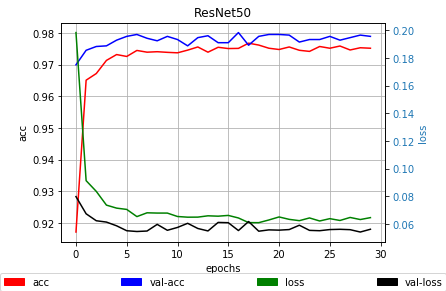

In [25]:
## 查看 history
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def read_history_from_file(filename):
    f = open(filename,'r')
    rdbuf = f.read()
    hist = eval(rdbuf)
    f.close()
    
    return hist
    
histfile = 'log/'+model_name+'_hist.txt'
hist = read_history_from_file(histfile)
print(hist)

title_name = model_name
show_history(hist, title_name)

### 用拟合后的模型预测

In [26]:
y_pred = model.predict(test_data, verbose=1)

12500/12500 [==============================] - 0s 36us/step


预测结果写入kaggle sample_submission.csv

In [27]:
y_pred = y_pred.clip(min=0.005, max=0.995)

import pandas as pd
from keras.preprocessing.image import *

df = pd.read_csv("sample_submission.csv")

gen = ImageDataGenerator()
test_generator = gen.flow_from_directory("pre-test", (224, 224), shuffle=False, 
                                         batch_size=16, class_mode=None)

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv(model_name+'pred.csv', index=None)
df.head(10)

Found 12500 images belonging to 1 classes.


/home/jerry/.local/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
5,6,0.005
6,7,0.005
7,8,0.005
8,9,0.005
9,10,0.005


### 模型可视化

In [1]:
from graphviz import Digraph

dot = Digraph(comment='The Model Chart')

dot.attr('node',shape='record')

dot.node('IN', 'Input|images')
dot.node('PRE-R', 'ResNet50|{input:|output:}|{(224, 224, 3)|(2048)}')
dot.node('PRE-X', 'Xception|{input:|output:}|{(299, 299, 3)|(2048)}')
dot.node('PRE-I', 'InceptionV3|{input:|output:}|{(299, 299, 3)|(2048)}')
dot.edge('IN', 'PRE-R')
dot.edge('IN', 'PRE-X')
dot.edge('IN', 'PRE-I')
# dot.edges(['AB', 'AL'])
# dot.edge('PRE-R', 'PRE-X', constraint='false')

dot.node('L3', 'Flatten|{input:|output:}|{(2048,3)|2048*3=6144}')
dot.edge('PRE-R', 'L3')
dot.edge('PRE-X', 'L3')
dot.edge('PRE-I', 'L3')

dot.node('L4', 'Dropout|Rate:|0.5')
dot.node('L5', 'Output|{input:|output:}|{6144|1}')
dot.edge('L3', 'L4')
dot.edge('L4', 'L5')

print(dot.source)
dot.render('model-table.gv', view=True)

// The Model Chart
digraph {
	node [shape=record]
	IN [label="Input|images"]
	"PRE-R" [label="ResNet50|{input:|output:}|{(224, 224, 3)|(2048)}"]
	"PRE-X" [label="Xception|{input:|output:}|{(299, 299, 3)|(2048)}"]
	"PRE-I" [label="InceptionV3|{input:|output:}|{(299, 299, 3)|(2048)}"]
	IN -> "PRE-R"
	IN -> "PRE-X"
	IN -> "PRE-I"
	L3 [label="Flatten|{input:|output:}|{(2048,3)|2048*3=6144}"]
	"PRE-R" -> L3
	"PRE-X" -> L3
	"PRE-I" -> L3
	L4 [label="Dropout|Rate:|0.5"]
	L5 [label="Output|{input:|output:}|{6144|1}"]
	L3 -> L4
	L4 -> L5
}


'model-table.gv.pdf'